# Ques 1 Implement a complete supervised learning pipeline (data preprocessing, model training, evaluation) on a real-world dataset (e.g., Loan Approval or Heart Disease). Justify your choices at each step.

In [2]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Example: use UCI-style CSV placed at ./data/loan_data.csv OR use sklearn's dataset as fallback
def load_data():
    import os
    path = './data/loan_data.csv'
    if os.path.exists(path):
        df = pd.read_csv(path)
    else:
        # fallback: use breast cancer dataset for binary classification
        from sklearn.datasets import load_breast_cancer
        data = load_breast_cancer(as_frame=True)
        df = data.frame
    return df

def main():
    df = load_data()
    print('Data preview:\n', df.head())
    # Basic target detection: if 'target' not in columns, try common names
    if 'target' in df.columns:
        y = df['target']
        X = df.drop(columns=['target'])
    elif 'Class' in df.columns:
        y = df['Class']
        X = df.drop(columns=['Class'])
    else:
        # assume last column is target
        y = df.iloc[:, -1]
        X = df.iloc[:, :-1]

    # Identify numeric and categorical columns
    num_cols = X.select_dtypes(include=['number']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

    # Preprocessing pipelines
    num_pipeline = Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    cat_pipeline = Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ])

    clf = Pipeline([
        ('pre', preprocessor),
        ('model', RandomForestClassifier(random_state=42, n_estimators=100))
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y if len(set(y))>1 else None)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    print('\nClassification report:\n', classification_report(y_test, preds))
    try:
        probs = clf.predict_proba(X_test)[:,1]
        print('\nROC AUC:', roc_auc_score(y_test, probs))
    except Exception:
        pass

if __name__ == '__main__':
    main()

Data preview:
    mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \

# Ques 2 Design a classification system using supervised learning to identify fake news articles. Compare logistic regression, decision trees, and SVM.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

# Load dataset
df = pd.read_csv(r"C:\Users\User\Downloads\fake_news.csv")  # assume dataset has 'text' and 'label'

# Split features and labels
X = df["text"]
y = df["label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorization (TF-IDF)
tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=50),
    "SVM": LinearSVC()
}

# Train & Evaluate
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    print(f"\n{name} Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))



Logistic Regression Results:
Accuracy: 0.9131807419100236
              precision    recall  f1-score   support

        FAKE       0.90      0.92      0.91       628
        REAL       0.92      0.90      0.91       639

    accuracy                           0.91      1267
   macro avg       0.91      0.91      0.91      1267
weighted avg       0.91      0.91      0.91      1267


Decision Tree Results:
Accuracy: 0.8050513022888713
              precision    recall  f1-score   support

        FAKE       0.80      0.80      0.80       628
        REAL       0.81      0.81      0.81       639

    accuracy                           0.81      1267
   macro avg       0.81      0.81      0.81      1267
weighted avg       0.81      0.81      0.81      1267


SVM Results:
Accuracy: 0.930544593528019
              precision    recall  f1-score   support

        FAKE       0.93      0.93      0.93       628
        REAL       0.93      0.93      0.93       639

    accuracy                

# Ques 3 Implement Ridge and Lasso regression on a multicollinear dataset. Analyze the effect of regularization using coefficient plots.

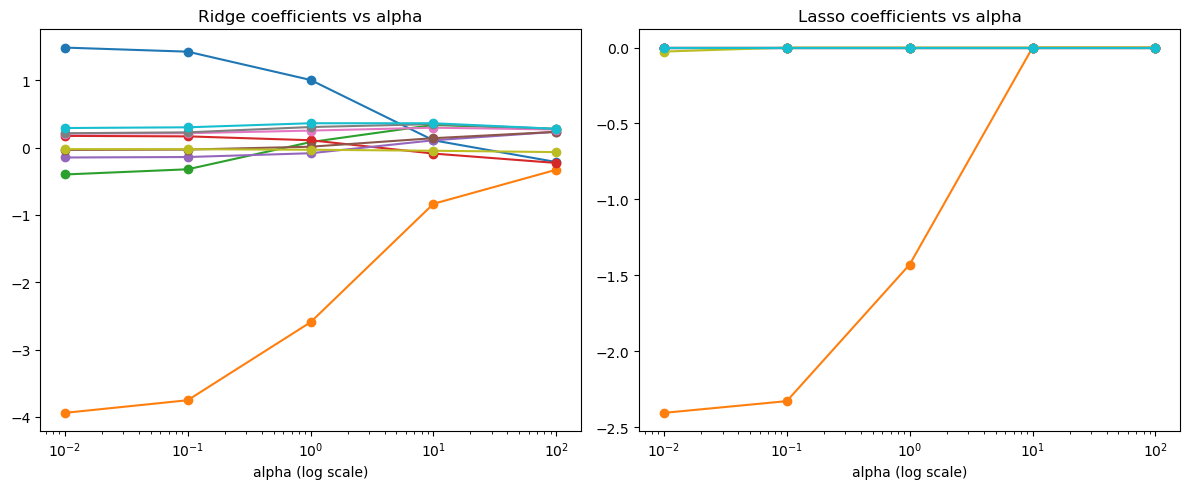

In [4]:

import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Create synthetic multicollinear dataset
def create_data(n=500, p=10, rho=0.95, random_state=42):
    rng = np.random.RandomState(random_state)
    # base signal
    z = rng.normal(size=(n,1))
    X = z @ (rng.normal(size=(1,p))) + rng.normal(scale=0.1, size=(n,p))
    # true coefficients
    coef = np.array([1.5, -2.0] + [0]*(p-2))
    y = X.dot(coef) + rng.normal(scale=0.5, size=n)
    return X, y

def main():
    X, y = create_data()
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    alphas = [0.01, 0.1, 1, 10, 100]
    ridge_coefs = []
    lasso_coefs = []
    for a in alphas:
        r = Ridge(alpha=a).fit(X_train_s, y_train)
        l = Lasso(alpha=a, max_iter=10000).fit(X_train_s, y_train)
        ridge_coefs.append(r.coef_)
        lasso_coefs.append(l.coef_)

    ridge_coefs = np.array(ridge_coefs)
    lasso_coefs = np.array(lasso_coefs)

    # coefficient plots
    fig, axes = plt.subplots(1,2, figsize=(12,5))
    for i in range(ridge_coefs.shape[1]):
        axes[0].plot(alphas, ridge_coefs[:,i], marker='o', label=f'coef_{i}')
    axes[0].set_xscale('log')
    axes[0].set_title('Ridge coefficients vs alpha')
    axes[0].set_xlabel('alpha (log scale)')

    for i in range(lasso_coefs.shape[1]):
        axes[1].plot(alphas, lasso_coefs[:,i], marker='o', label=f'coef_{i}')
    axes[1].set_xscale('log')
    axes[1].set_title('Lasso coefficients vs alpha')
    axes[1].set_xlabel('alpha (log scale)')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

# Ques 4 Train logistic regression with L1 and L2 regularization. Compare sparsity and accuracy.

In [5]:


import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

def main():
    data = load_breast_cancer()
    X = data.data
    y = data.target
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
    scaler = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_test_s = scaler.transform(X_test)

    models = {
        'L1': LogisticRegression(penalty='l1', solver='saga', max_iter=5000, C=1.0),
        'L2': LogisticRegression(penalty='l2', solver='lbfgs', max_iter=5000, C=1.0)
    }
    for name, model in models.items():
        model.fit(X_train_s, y_train)
        preds = model.predict(X_test_s)
        print('\n---', name, '---')
        print('Accuracy:', accuracy_score(y_test, preds))
        # sparsity
        coef = model.coef_.ravel()
        nonzero = np.sum(coef != 0)
        print('Number of non-zero coefficients:', int(nonzero), '/', coef.size)
        print(classification_report(y_test, preds))

if __name__ == '__main__':
    main()


--- L1 ---
Accuracy: 0.9912280701754386
Number of non-zero coefficients: 18 / 30
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        42
           1       0.99      1.00      0.99        72

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114


--- L2 ---
Accuracy: 0.9824561403508771
Number of non-zero coefficients: 30 / 30
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



# Ques 5 Perform feature selection using backward elimination and compare it with Lasso regression.

In [6]:


import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

def main():
    data = load_breast_cancer()
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = data.target
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
    scaler = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_test_s = scaler.transform(X_test)

    # Backward elimination via RFE (Recursive Feature Elimination) with logistic regression
    model = LogisticRegression(max_iter=5000)
    selector = RFE(model, n_features_to_select=10, step=1)
    selector = selector.fit(X_train_s, y_train)
    selected_features = X.columns[selector.support_]
    print('RFE selected features:', list(selected_features))
    preds_rfe = model.fit(X_train_s[:, selector.support_], y_train).predict(X_test_s[:, selector.support_])
    print('RFE accuracy:', accuracy_score(y_test, preds_rfe))

    # Lasso feature selection
    lasso = LassoCV(cv=5, max_iter=10000).fit(X_train_s, y_train)
    coef = pd.Series(lasso.coef_, index=X.columns)
    selected_lasso = list(coef[coef!=0].index)
    print('Lasso selected features:', selected_lasso)
    if selected_lasso:
        preds_lasso = LogisticRegression(max_iter=5000).fit(X_train_s[:, coef!=0], y_train).predict(X_test_s[:, coef!=0])
        print('Lasso-based logistic accuracy:', accuracy_score(y_test, preds_lasso))

if __name__ == '__main__':
    main()

RFE selected features: ['mean area', 'radius error', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst concavity', 'worst concave points']
RFE accuracy: 0.9736842105263158
Lasso selected features: ['mean texture', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst area', 'worst smoothness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
Lasso-based logistic accuracy: 0.9824561403508771


# Ques 6 Train a decision tree on a medical dataset (e.g., diabetes) and prune it to avoid overfitting. Demonstrate pruning using both cost complexity and depth control.

Unpruned Tree:
Train RMSE: 0.0
Test RMSE: 70.54642267903446
----------------------------------------


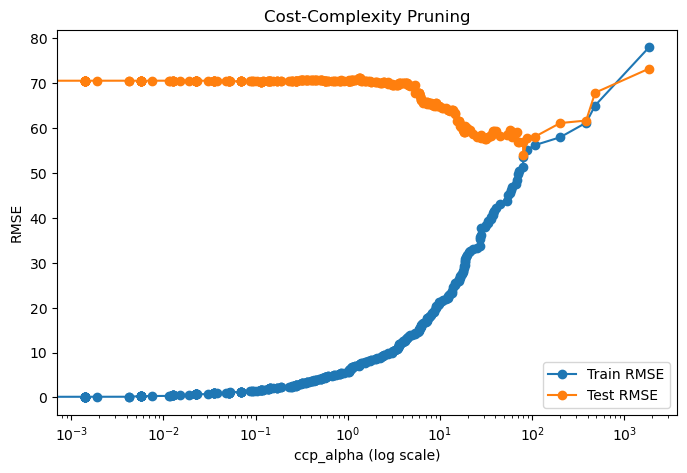

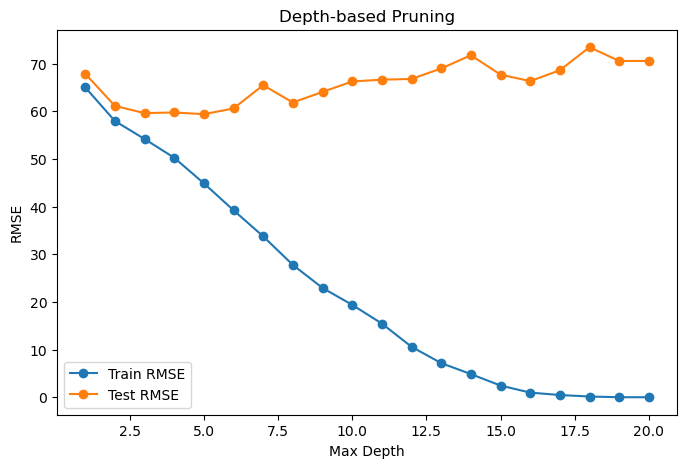

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    """Helper function to compute RMSE."""
    return np.sqrt(mean_squared_error(y_true, y_pred))

def main():
    # Load dataset
    data = load_diabetes()
    X, y = data.data, data.target

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Fully grown tree (no pruning)
    dt = DecisionTreeRegressor(random_state=42)
    dt.fit(X_train, y_train)
    print("Unpruned Tree:")
    print("Train RMSE:", rmse(y_train, dt.predict(X_train)))
    print("Test RMSE:", rmse(y_test, dt.predict(X_test)))
    print("-" * 40)

    # --------------------------
    # 1️⃣ Cost-Complexity Pruning
    # --------------------------
    path = dt.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas = path.ccp_alphas

    clfs = []
    for alpha in ccp_alphas:
        clf = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha)
        clf.fit(X_train, y_train)
        clfs.append(clf)

    train_rmse = [rmse(y_train, c.predict(X_train)) for c in clfs]
    test_rmse = [rmse(y_test, c.predict(X_test)) for c in clfs]

    plt.figure(figsize=(8, 5))
    plt.plot(ccp_alphas, train_rmse, marker='o', label="Train RMSE")
    plt.plot(ccp_alphas, test_rmse, marker='o', label="Test RMSE")
    plt.xlabel("ccp_alpha (log scale)")
    plt.ylabel("RMSE")
    plt.title("Cost-Complexity Pruning")
    plt.legend()
    plt.xscale("log")
    plt.show()

    # --------------------------
    # 2️⃣ Depth-based Pruning
    # --------------------------
    depths = range(1, 21)
    train_rmse_depth, test_rmse_depth = [], []

    for d in depths:
        clf = DecisionTreeRegressor(random_state=42, max_depth=d)
        clf.fit(X_train, y_train)
        train_rmse_depth.append(rmse(y_train, clf.predict(X_train)))
        test_rmse_depth.append(rmse(y_test, clf.predict(X_test)))

    plt.figure(figsize=(8, 5))
    plt.plot(depths, train_rmse_depth, marker='o', label="Train RMSE")
    plt.plot(depths, test_rmse_depth, marker='o', label="Test RMSE")
    plt.xlabel("Max Depth")
    plt.ylabel("RMSE")
    plt.title("Depth-based Pruning")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


# Ques 7 Visualize the feature importance in a random forest trained on a tabular dataset and interpret the top features.

Top features:
 worst perimeter         0.133100
worst area              0.128052
worst concave points    0.108107
mean concave points     0.094414
worst radius            0.090639
mean radius             0.058662
mean perimeter          0.055242
mean area               0.049938
mean concavity          0.046207
worst concavity         0.035357
dtype: float64


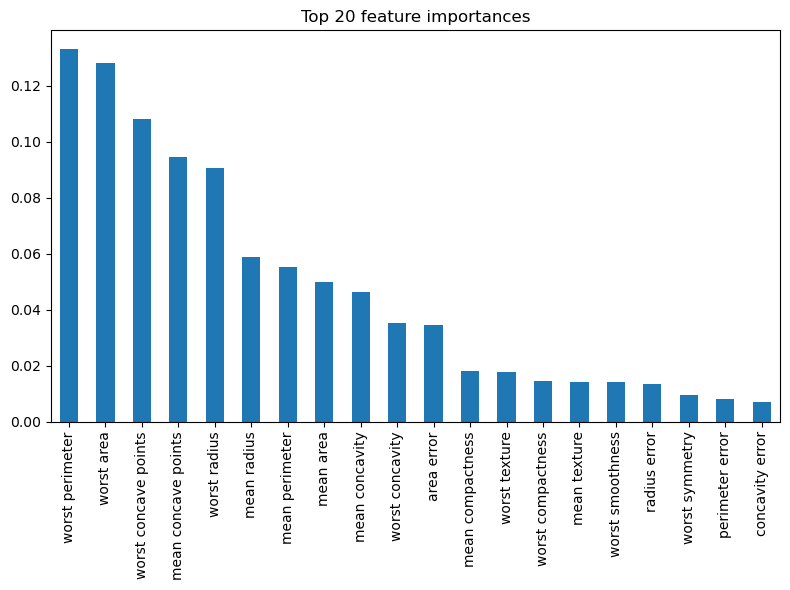

In [11]:


import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def main():
    data = load_breast_cancer()
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = data.target
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    print('Top features:\n', importances.head(10))
    plt.figure(figsize=(8,6))
    importances.head(20).plot(kind='bar')
    plt.title('Top 20 feature importances')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

# Ques 8 Create an ensemble voting classifier using logistic regression, decision trees, and SVM. Evaluate ensemble vs. individual models.

In [12]:


import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score,classification_report

def main():
    data = load_iris()
    X = data.data
    y = data.target
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
    lr = LogisticRegression(max_iter=2000)
    dt = DecisionTreeClassifier(max_depth=5)
    svc = SVC(probability=True)
    ensemble = VotingClassifier(estimators=[('lr',lr),('dt',dt),('svc',svc)], voting='soft')
    for name, model in [('Logistic',lr),('DecisionTree',dt),('SVC',svc),('Ensemble',ensemble)]:
        model.fit(X_train,y_train)
        preds = model.predict(X_test)
        print('\n==', name, 'Accuracy:', accuracy_score(y_test,preds))
        print(classification_report(y_test,preds))

if __name__ == '__main__':
    main()


== Logistic Accuracy: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


== DecisionTree Accuracy: 0.9333333333333333
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


== SVC Accuracy: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
    

# Ques 9 Compare the performance of Bagging and Boosting using multiple base learners (Decision Tree,KNN, Logistic Regression).

In [17]:

import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

def main():
    X, y = make_classification(n_samples=2000, n_features=20, n_informative=8, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
    base_learners = {
        'DecisionTree': DecisionTreeClassifier(max_depth=4),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'Logistic': LogisticRegression(max_iter=2000)
    }
    for name, base in base_learners.items():
        bag = BaggingClassifier(estimator=base, n_estimators=50, random_state=42)
        ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=42)
        gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
        for model_name, model in [('Bagging',bag),('AdaBoost',ada),('GradientBoosting',gb)]:
            model.fit(X_train,y_train)
            preds = model.predict(X_test)
            print(f'\nBase: {name} | Model: {model_name} | Acc: {accuracy_score(y_test,preds)}')
            print(classification_report(y_test,preds))

if __name__ == '__main__':
    main()


Base: DecisionTree | Model: Bagging | Acc: 0.7675
              precision    recall  f1-score   support

           0       0.81      0.70      0.75       200
           1       0.74      0.83      0.78       200

    accuracy                           0.77       400
   macro avg       0.77      0.77      0.77       400
weighted avg       0.77      0.77      0.77       400


Base: DecisionTree | Model: AdaBoost | Acc: 0.745
              precision    recall  f1-score   support

           0       0.76      0.71      0.74       200
           1       0.73      0.78      0.75       200

    accuracy                           0.74       400
   macro avg       0.75      0.74      0.74       400
weighted avg       0.75      0.74      0.74       400


Base: DecisionTree | Model: GradientBoosting | Acc: 0.825
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       200
           1       0.82      0.82      0.82       200

    accuracy         

# Ques 10 Analyze the effect of the number of estimators and learning rate on AdaBoost using a grid search.

In [20]:


import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, accuracy_score

def main():
    X, y = make_classification(n_samples=2000, n_features=20, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0]
    }
    gs = GridSearchCV(ada, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    gs.fit(X_train, y_train)
    print('Best params:', gs.best_params_)
    best = gs.best_estimator_
    preds = best.predict(X_test)
    print('Test accuracy:', accuracy_score(y_test, preds))
    print(classification_report(y_test, preds))

if __name__ == '__main__':
    main()

Best params: {'learning_rate': 1.0, 'n_estimators': 100}
Test accuracy: 0.92
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       204
           1       0.92      0.92      0.92       196

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



# Ques 11 Implement a stacking classifier using logistic regression as a meta-learner. Compare its performance with bagging and boosting.

In [21]:


import numpy as np
from sklearn.datasets import load_wine, make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

def main():
    X, y = make_classification(n_samples=1500, n_features=25, n_informative=10, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
    estimators = [
        ('dt', DecisionTreeClassifier(max_depth=5)),
        ('svc', SVC(probability=True))
    ]
    stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=2000), cv=5)
    stack.fit(X_train, y_train)
    preds = stack.predict(X_test)
    print('Stacking acc:', accuracy_score(y_test, preds))
    print(classification_report(y_test, preds))

    # Quick comparison with bagging and boosting
    bag = BaggingClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=50).fit(X_train,y_train)
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=50).fit(X_train,y_train)
    for name, model in [('Bagging',bag), ('AdaBoost', ada)]:
        p = model.predict(X_test)
        print(f'\n{name} acc:', accuracy_score(y_test,p))
        print(classification_report(y_test,p))

if __name__ == '__main__':
    main()


Stacking acc: 0.8933333333333333
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       150
           1       0.89      0.89      0.89       150

    accuracy                           0.89       300
   macro avg       0.89      0.89      0.89       300
weighted avg       0.89      0.89      0.89       300


Bagging acc: 0.8466666666666667
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       150
           1       0.87      0.81      0.84       150

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.85      0.85      0.85       300


AdaBoost acc: 0.81
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       150
           1       0.81      0.81      0.81       150

    accuracy                           0.81       300
   macro avg       0.81      0.81      0.8

# Ques 12 Use SVM with different kernels (linear, polynomial, RBF) and visualize decision boundaries. Use grid search to optimize kernel parameters.

Training linear


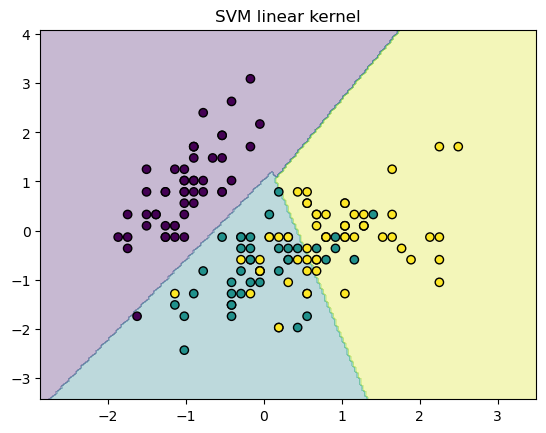

Training poly


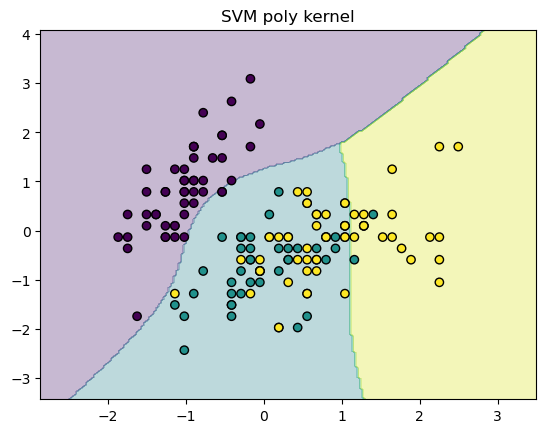

Training rbf


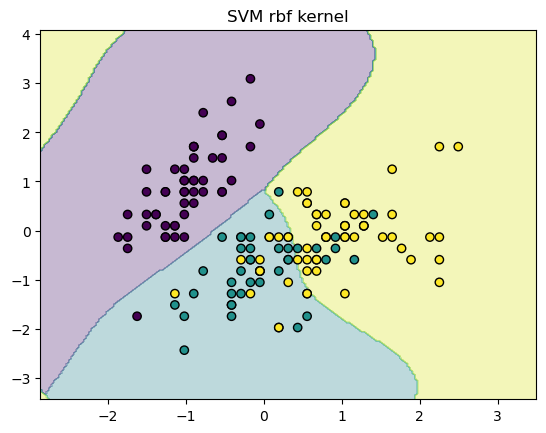

Best params (RBF): {'C': 10, 'gamma': 'scale'}


In [22]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

def plot_boundary(clf, X, y, title):
    # Only works for 2D data
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min,x_max,200), np.linspace(y_min,y_max,200))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx,yy,Z, alpha=0.3)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolor='k')
    plt.title(title)
    plt.show()

def main():
    iris = datasets.load_iris()
    X = iris.data[:, :2]  # reduce to 2D for visualization
    y = iris.target
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)
    models = {
        'linear': svm.SVC(kernel='linear'),
        'poly': svm.SVC(kernel='poly', degree=3),
        'rbf': svm.SVC(kernel='rbf')
    }
    for name, model in models.items():
        model.fit(Xs, y)
        print('Training', name)
        plot_boundary(model, Xs, y, f'SVM {name} kernel')

    # grid search for RBF
    param_grid = {'C':[0.1,1,10], 'gamma':['scale','auto',0.1,1]}
    gs = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=3)
    gs.fit(Xs, y)
    print('Best params (RBF):', gs.best_params_)

if __name__ == '__main__':
    main()

# Ques 13 Perform multi-class classification using One-vs-One and One-vs-Rest SVM strategies. Compare the confusion matrices.


== OVO
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

Confusion matrix:
 [[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]


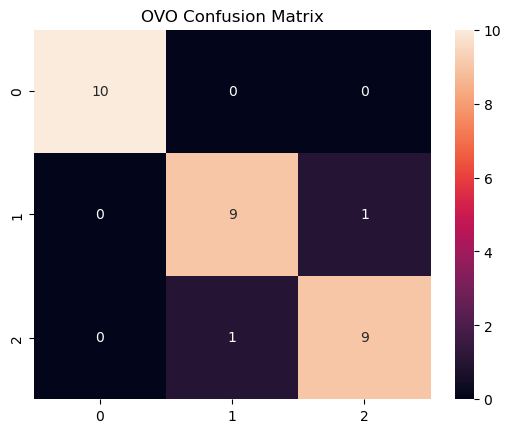


== OVR
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

Confusion matrix:
 [[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]


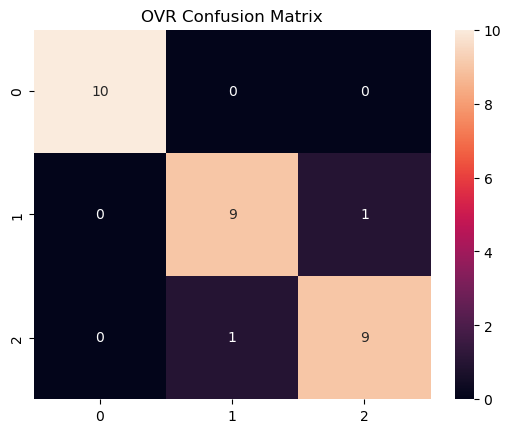

In [23]:

import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def main():
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
    ovo = OneVsOneClassifier(SVC())
    ovr = OneVsRestClassifier(SVC())
    ovo.fit(X_train, y_train)
    ovr.fit(X_train, y_train)
    for name, model in [('OVO', ovo), ('OVR', ovr)]:
        preds = model.predict(X_test)
        print('\n==', name)
        print(classification_report(y_test, preds))
        cm = confusion_matrix(y_test, preds)
        print('Confusion matrix:\n', cm)
        plt.figure()
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title(name + ' Confusion Matrix')
        plt.show()

if __name__ == '__main__':
    main()

# Ques 14 Apply SVM for high-dimensional text classification (e.g., spam filtering) using TF-IDF and explain its advantages.

In [38]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load the uploaded dataset
df = pd.read_csv(r"C:\Users\User\Downloads\archive (3)\spam.csv",encoding="latin-1")

# Inspect columns to find the right text/label columns
print("Columns:", df.columns)

# Clean up unnecessary columns (your dataset usually has some empty ones)
df = df[['v1', 'v2']]
df.columns = ['label', 'text']

# Convert labels: ham = 0, spam = 1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Features (X) and target (y)
X = df['text']
y = df['label']

# TF-IDF vectorization
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=20000, stop_words='english')
X_tfidf = vectorizer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# Train the SVM classifier
model = LinearSVC()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nAdvantages of using SVM for high-dimensional text classification:")
print("- Works well with sparse TF-IDF features (common in text data).")
print("- Finds the best separating hyperplane between spam and ham messages.")
print("- Resistant to overfitting with high-dimensional data.")
print("- Effective with a clear margin of separation.")


Columns: Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

Classification Report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.98      0.85      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115


Advantages of using SVM for high-dimensional text classification:
- Works well with sparse TF-IDF features (common in text data).
- Finds the best separating hyperplane between spam and ham messages.
- Resistant to overfitting with high-dimensional data.
- Effective with a clear margin of separation.


# Ques 15 Create a confusion matrix and classification report for a multi-class classifier. Interpret results and suggest ways to improve precision.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



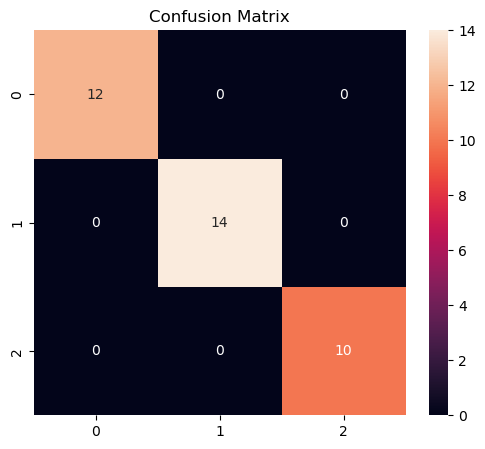

Suggestions to improve precision: collect more data, calibrate thresholds, feature engineering, balance classes, tune model hyperparameters.


In [39]:


import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

def main():
    data = load_wine()
    X = data.data
    y = data.target
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    print(classification_report(y_test, preds))
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.show()
    print('Suggestions to improve precision: collect more data, calibrate thresholds, feature engineering, balance classes, tune model hyperparameters.')

if __name__ == '__main__':
    main()

# Ques 16 Use k-fold cross-validation to evaluate and compare the performance of at least three supervised models. Visualize variation in performance.

Logistic mean acc: 0.9543393882937432 std: 0.018683901532046732
RandomForest mean acc: 0.956078248719143 std: 0.009553115647988178
SVC mean acc: 0.9138953578636858 std: 0.0243972084272489


C:\Users\User\AppData\Local\Temp\ipykernel_1060\1317523867.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([results[m] for m in results.keys()], labels=list(results.keys()))


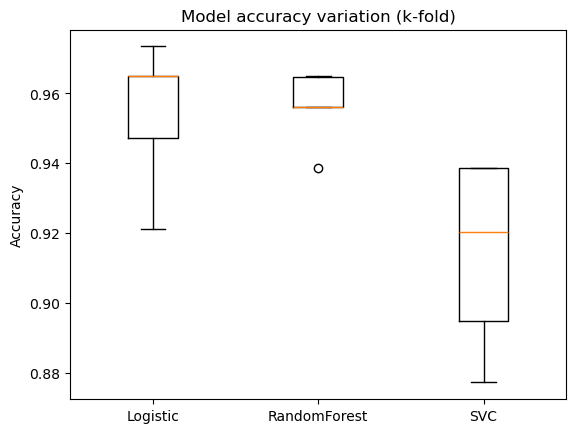

In [40]:

import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt

def main():
    data = load_breast_cancer()
    X = data.data
    y = data.target
    models = {
        'Logistic': LogisticRegression(max_iter=5000),
        'RandomForest': RandomForestClassifier(n_estimators=200),
        'SVC': SVC()
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = {}
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
        results[name] = scores
        print(name, 'mean acc:', scores.mean(), 'std:', scores.std())
    # visualize
    plt.boxplot([results[m] for m in results.keys()], labels=list(results.keys()))
    plt.title('Model accuracy variation (k-fold)')
    plt.ylabel('Accuracy')
    plt.show()

if __name__ == '__main__':
    main()

# Ques 17 Implement hyperparameter tuning for Random Forest, SVM, and Gradient Boosting using GridSearchCV and RandomizedSearchCV.

In [41]:


import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report

def main():
    X, y = make_classification(n_samples=2000, n_features=30, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    # Random Forest Grid
    rf = RandomForestClassifier(random_state=42)
    rf_grid = {'n_estimators':[100,200],'max_depth':[None,10,20]}
    gs_rf = GridSearchCV(rf, rf_grid, cv=3, n_jobs=-1)
    gs_rf.fit(X_train, y_train)
    print('RF best:', gs_rf.best_params_)
    # SVM Randomized
    svc = SVC()
    svc_dist = {'C':[0.1,1,10],'kernel':['rbf','linear']}
    rs_svc = RandomizedSearchCV(svc, svc_dist, n_iter=6, cv=3, n_jobs=-1, random_state=42)
    rs_svc.fit(X_train, y_train)
    print('SVC best:', rs_svc.best_params_)
    # Gradient Boosting Grid
    gb = GradientBoostingClassifier(random_state=42)
    gb_grid = {'n_estimators':[100,200], 'learning_rate':[0.01,0.1]}
    gs_gb = GridSearchCV(gb, gb_grid, cv=3, n_jobs=-1)
    gs_gb.fit(X_train, y_train)
    print('GB best:', gs_gb.best_params_)

if __name__ == '__main__':
    main()

RF best: {'max_depth': None, 'n_estimators': 200}
SVC best: {'kernel': 'rbf', 'C': 0.1}
GB best: {'learning_rate': 0.1, 'n_estimators': 100}


# Ques 18 Design a machine learning model to predict employee attrition in an organization. Evaluate business impact and explain interpretability.

In [42]:


import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Place dataset at ./data/employee_attrition.csv with 'Attrition' column (1=yes,0=no)
def load_data():
    import os
    path = './data/employee_attrition.csv'
    if os.path.exists(path):
        return pd.read_csv(path)
    else:
        # synthetic small dataset
        return pd.DataFrame({
            'Age':[29,35,50,23,40,30],
            'MonthlyIncome':[3000,6000,15000,2200,8000,4000],
            'YearsAtCompany':[1,5,20,0,10,2],
            'Attrition':[1,0,0,1,0,1]
        })

def main():
    df = load_data()
    print('Preview:', df.head())
    if 'Attrition' not in df.columns:
        raise ValueError('Dataset must contain Attrition column')
    y = df['Attrition']
    X = df.drop(columns=['Attrition'])
    # simple model
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
    model = RandomForestClassifier(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(classification_report(y_test, preds))
    # Interpretability: feature importances
    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print('Feature importances:\n', importances)
    # Business impact: compute how many employees predicted to leave and potential cost (example assumptions)
    predicted_leave = (model.predict(X) == 1).sum()
    avg_replacement_cost = 20000  # example
    print(f'Predicted leavers: {predicted_leave}, estimated replacement cost: {predicted_leave * avg_replacement_cost}')

if __name__ == '__main__':
    main()

Preview:    Age  MonthlyIncome  YearsAtCompany  Attrition
0   29           3000               1          1
1   35           6000               5          0
2   50          15000              20          0
3   23           2200               0          1
4   40           8000              10          0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Feature importances:
 MonthlyIncome     0.357955
Age               0.323864
YearsAtCompany    0.318182
dtype: float64
Predicted leavers: 3, estimated replacement cost: 60000


# Ques 19 Create a real-time ML model using Flask or Streamlit to classify sentiment (positive/negative) from user reviews. Use logistic regression or SVM.

In [49]:

import streamlit as st
import joblib
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Simple streamlit app to classify sentiment using a pretrained model or train on small data
def train_sample_model():
    # tiny sample training for demo only
    data = pd.DataFrame({
        'text':['I love this product','This is terrible','Absolutely fantastic','Worst ever','Good value'],
        'label':[1,0,1,0,1]
    })
    vec = TfidfVectorizer(stop_words='english', max_features=5000)
    X = vec.fit_transform(data['text'])
    model = LogisticRegression()
    model.fit(X, data['label'])
    joblib.dump((vec, model), 'sentiment_model.joblib')
    return vec, model

def main():
    st.title('Real-time Sentiment Classifier (Demo)')
    st.write('Enter a review to classify positive (1) or negative (0).')
    if st.button('Train demo model'):
        vec, model = train_sample_model()
        st.success('Demo model trained and saved to sentiment_model.joblib')
    uploaded = st.text_area('Type review here')
    if st.button('Classify'):
        try:
            vec, model = joblib.load('sentiment_model.joblib')
        except Exception:
            vec, model = train_sample_model()
        X = vec.transform([uploaded])
        pred = model.predict(X)[0]
        proba = model.predict_proba(X)[0] if hasattr(model, 'predict_proba') else None
        st.write('Prediction:', int(pred))
        if proba is not None:
            st.write('Probability:', proba)

if __name__ == '__main__':
    main()

2025-10-04 20:42:43.310 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-04 20:42:43.659 
  command:

    streamlit run C:\Users\User\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-10-04 20:42:43.662 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-04 20:42:43.665 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-04 20:42:43.681 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-04 20:42:43.685 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-04 20:42:43.688 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-04 20:42:43.694 Thread 'MainThread': mis